# Involving libraries


In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data set -INFO


In [2]:
dataset_path = '/home/bot/myprojectdir/dataset/'

In [3]:
df = pd.read_csv(dataset_path+'processed/cleanDatasetWithEncoding.csv')

In [4]:
df.columns

Index(['DestinationPort', 'FlowDuration', 'TotalFwdPackets',
       'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowBytess', 'FlowPacketss', 'FlowIATMean', 'FlowIATStd', 'FlowIATMax',
       'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd', 'FwdIATMax',
       'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd', 'BwdIATMax',
       'BwdIATMin', 'FwdPSHFlags', 'FwdURGFlags', 'FwdHeaderLength',
       'BwdHeaderLength', 'FwdPacketss', 'BwdPacketss', 'MinPacketLength',
       'MaxPacketLength', 'PacketLengthMean', 'PacketLengthStd',
       'PacketLengthVariance', 'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount',
       'PSHFlagCount', 'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount',
       'ECEFlagCount', 'DownUpRatio', 'AveragePacketSize', 'AvgFw

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520911 entries, 0 to 2520910
Data columns (total 71 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   DestinationPort          float64
 1   FlowDuration             float64
 2   TotalFwdPackets          float64
 3   TotalBackwardPackets     float64
 4   TotalLengthofFwdPackets  float64
 5   TotalLengthofBwdPackets  float64
 6   FwdPacketLengthMax       float64
 7   FwdPacketLengthMin       float64
 8   FwdPacketLengthMean      float64
 9   FwdPacketLengthStd       float64
 10  BwdPacketLengthMax       float64
 11  BwdPacketLengthMin       float64
 12  BwdPacketLengthMean      float64
 13  BwdPacketLengthStd       float64
 14  FlowBytess               float64
 15  FlowPacketss             float64
 16  FlowIATMean              float64
 17  FlowIATStd               float64
 18  FlowIATMax               float64
 19  FlowIATMin               float64
 20  FwdIATTotal              float64
 21  FwdIATMe

# Data classification
Preparation of training data

In [6]:
df['Label'].value_counts()

14    2095170
3      172846
1      128014
9       90694
2       10286
6        5931
5        5385
4        5228
10       3219
0        1948
11       1470
13        652
8          36
12         21
7          11
Name: Label, dtype: int64

In [7]:
old_memory_usage = df.memory_usage().sum()
#change the variable types for low memory usage
#int64 to int32,,, float64 to float32
integer = []
f = []
for i in df.columns[:-1]:
    if df[i].dtype == "int64": integer.append(i)
    else : f.append(i)

df[integer] = df[integer].astype("int32")
df[f] = df[f].astype("float32")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520911 entries, 0 to 2520910
Data columns (total 71 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   DestinationPort          float32
 1   FlowDuration             float32
 2   TotalFwdPackets          float32
 3   TotalBackwardPackets     float32
 4   TotalLengthofFwdPackets  float32
 5   TotalLengthofBwdPackets  float32
 6   FwdPacketLengthMax       float32
 7   FwdPacketLengthMin       float32
 8   FwdPacketLengthMean      float32
 9   FwdPacketLengthStd       float32
 10  BwdPacketLengthMax       float32
 11  BwdPacketLengthMin       float32
 12  BwdPacketLengthMean      float32
 13  BwdPacketLengthStd       float32
 14  FlowBytess               float32
 15  FlowPacketss             float32
 16  FlowIATMean              float32
 17  FlowIATStd               float32
 18  FlowIATMax               float32
 19  FlowIATMin               float32
 20  FwdIATTotal              float32
 21  FwdIATMe

In [8]:
new_memory_usage = df.memory_usage().sum()
old_vs_new = (old_memory_usage - new_memory_usage) / old_memory_usage * 100
print(f"%{old_vs_new} lower memory usage")

%49.295770241184364 lower memory usage


In [9]:
# drop one variable features 
one_variable_list = []
for i in df.columns:
    if df[i].value_counts().nunique() < 2:
        one_variable_list.append(i)
df.drop(one_variable_list,axis=1,inplace=True)
df.columns =  df.columns.str.strip()

In [10]:
# drop nan and infinite rows
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [11]:
# drop duplicate rows
df =  df.drop_duplicates(keep="first")
df.reset_index(drop=True,inplace=True)

In [12]:
#feature reduction 
#dropping very high correlated features 
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df =  df.drop(to_drop, axis=1)
df.shape

/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(2497928, 48)

In [13]:
x = df.drop(["Label"],axis=1)
y = df["Label"]

# Model training

In [14]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# Data splitting
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.35,random_state=42,stratify=y)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
#Fitting Models
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

startNB = time.time()


# Naive Baye model training
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
print("Naive Bayes training time", time.time()-startNB)

startDT = time.time()
# Training Decision Tree models
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=0)
#The division quality measurement function supports the "die" criteria for dirt and the "entropy" criteria for obtaining information,
DTC_Classifier.fit(X_train, Y_train)
print("Training time model decision tree", time.time()-startDT)

startKNN = time.time()
# Training KNeighborsClassifier model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1, n_neighbors=3, metric='minkowski', algorithm='auto') 
#n_jobs = -1 means it uses all processors, algorithm = 'auto' itself applies the appropriate algorithm based on passed values, n_neighbors = 3 takes into account 3 nearest neighbors, eucledian distance
KNN_Classifier.fit(X_train, Y_train); 
print("KNN model training time", time.time()-startKNN)

Naive Bayes training time 1.892601490020752
Training time model decision tree 56.73295021057129
KNN model training time 0.1525564193725586


In [17]:
logmodel = LogisticRegression(max_iter=1000,multi_class='ovr', n_jobs=-1, random_state=1, solver='saga')
st_time = time.time()
logmodel.fit(X_train, Y_train)
end_time = time.time()
print('Training time for Logistic Regression= %s'%(end_time-st_time))

Training time for Logistic Regression= 154.14876461029053


# Model evaluation

In [18]:
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support,balanced_accuracy_score, f1_score, precision_score, recall_score
def evaluate(y_test, predictions):
    report = classification_report(y_test,predictions)
    micro_avg = list(precision_recall_fscore_support(y_test,predictions,average='micro'))
    print("### OVERALL REPORT ###")
    print(report)
    print('### MICRO AVERAGE ###')
    plt.figure(figsize=(15,10)) # (width, height)
    print('### Weighted F1 ###')
    print("Weighted f1 = "+str(format(f1_score(y_test,predictions, average='weighted'),'.4f'))+"\n")
    print('### Weighted Precision and Recall')
    print("Weighted precision = "+str(format(precision_score(y_test,predictions, average='weighted'),'.4f'))+"\nWeighted recall = "+str(format(recall_score(y_test,predictions, average='weighted'),'.4f'))+"\n")
    sns.heatmap(confusion_matrix(y_test,predictions),xticklabels= ['Bot','DDoS','DoSGoldenEye','DoSHulk','DoSSlowhttptest','DoSslowloris','FTPPatator','Heartbleed','Infiltration','PortScan','SSHPatator','WebAttackBruteForce','WebAttackSqlInjection','WebAttackXSS','normal'], yticklabels=['Bot','DDoS','DoSGoldenEye','DoSHulk','DoSSlowhttptest','DoSslowloris','FTPPatator','Heartbleed','Infiltration','PortScan','SSHPatator','WebAttackBruteForce','WebAttackSqlInjection','WebAttackXSS','normal'],annot=True,fmt='g')

In [19]:
st_time = time.time()
knn_predictions = KNN_Classifier.predict(X_test)
end_time = time.time()
print('Prediction time for KNN testing data = %s'%(end_time-st_time))

Prediction time for KNN testing data = 37502.60096716881


In [20]:
st_time =time.time()
dt_predictions = DTC_Classifier.predict(X_test)
end_time = time.time()
print('Prediction time for Decision Tree testing data = %s'%(end_time-st_time))

Prediction time for Decision Tree testing data = 0.16055679321289062


In [21]:
st_time = time.time()
bnb_predictions = BNB_Classifier.predict(X_test)
end_time = time.time()
print('Prediction time for Naive Bayes testing data = %s'%(end_time-st_time))

Prediction time for Naive Bayes testing data = 0.7687621116638184


In [22]:
st_time = time.time()
lr_predictions = logmodel.predict(X_test)
end_time = time.time()
print('Prediction time for Logistic Regression testing data = %s'%(end_time-st_time))

Prediction time for Logistic Regression testing data = 0.14893746376037598


/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       682
           1       1.00      1.00      1.00     44805
           2       0.98      0.99      0.98      3599
           3       1.00      1.00      1.00     60496
           4       0.98      0.99      0.99      1830
           5       0.99      0.99      0.99      1881
           6       1.00      0.99      1.00      2076
           7       1.00      1.00      1.00         4
           8       1.00      0.25      0.40        12
           9       0.93      0.96      0.95     31743
          10       0.96      0.97      0.97      1127
          11       0.68      0.74      0.71       514
          12       0.00      0.00      0.00         7
          13       0.38      0.32      0.35       228
          14       1.00      1.00      1.00    725271

    accuracy                           0.99    874275
   macro avg       0.84      0.79      0.80    874275
wei

/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted precision = 0.9946
Weighted recall = 0.9946



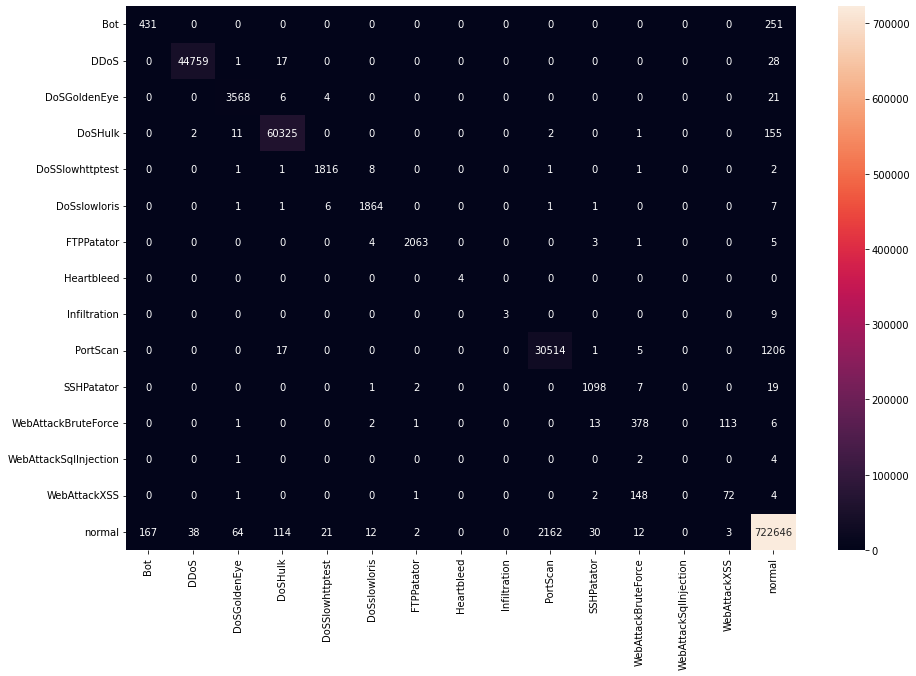

In [25]:
evaluate(Y_test,knn_predictions)

### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       682
           1       1.00      1.00      1.00     44805
           2       0.99      0.99      0.99      3599
           3       1.00      1.00      1.00     60496
           4       0.98      0.99      0.98      1830
           5       0.99      0.99      0.99      1881
           6       1.00      1.00      1.00      2076
           7       0.67      1.00      0.80         4
           8       0.64      0.75      0.69        12
           9       0.99      0.99      0.99     31743
          10       1.00      1.00      1.00      1127
          11       0.73      0.74      0.73       514
          12       0.50      0.29      0.36         7
          13       0.41      0.40      0.40       228
          14       1.00      1.00      1.00    725271

    accuracy                           1.00    874275
   macro avg       0.85      0.86      0.85    874275
wei

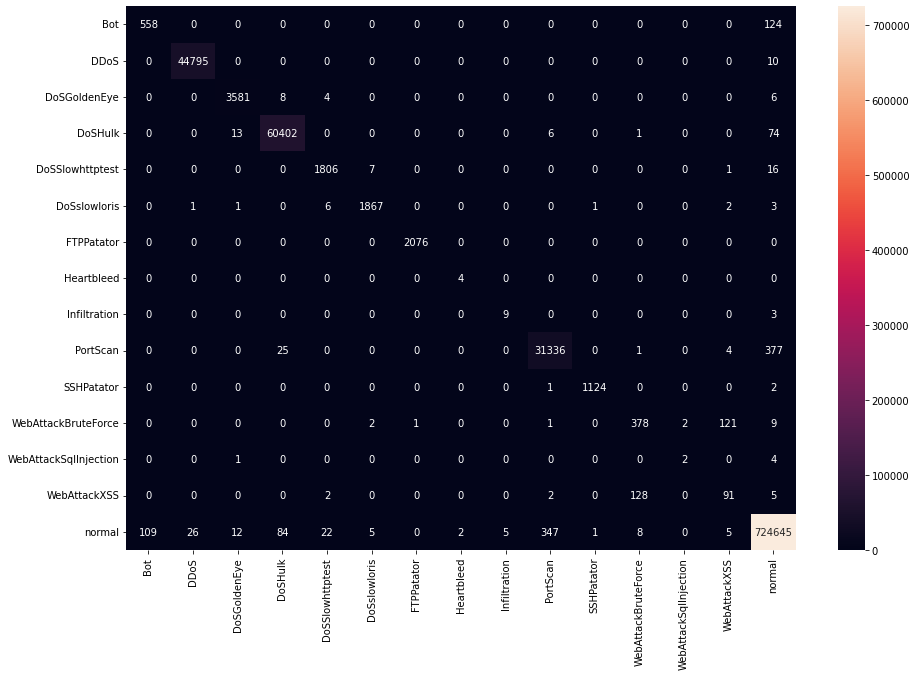

In [26]:
evaluate(Y_test,dt_predictions)

### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       682
           1       0.69      0.69      0.69     44805
           2       0.08      0.68      0.14      3599
           3       0.80      0.82      0.81     60496
           4       0.12      0.73      0.21      1830
           5       0.06      0.60      0.11      1881
           6       0.53      0.66      0.59      2076
           7       0.00      1.00      0.00         4
           8       0.00      0.92      0.00        12
           9       0.72      0.98      0.83     31743
          10       0.18      0.91      0.30      1127
          11       0.02      0.29      0.05       514
          12       0.00      0.00      0.00         7
          13       0.02      0.81      0.04       228
          14       0.97      0.80      0.88    725271

    accuracy                           0.80    874275
   macro avg       0.28      0.66      0.31    874275
wei

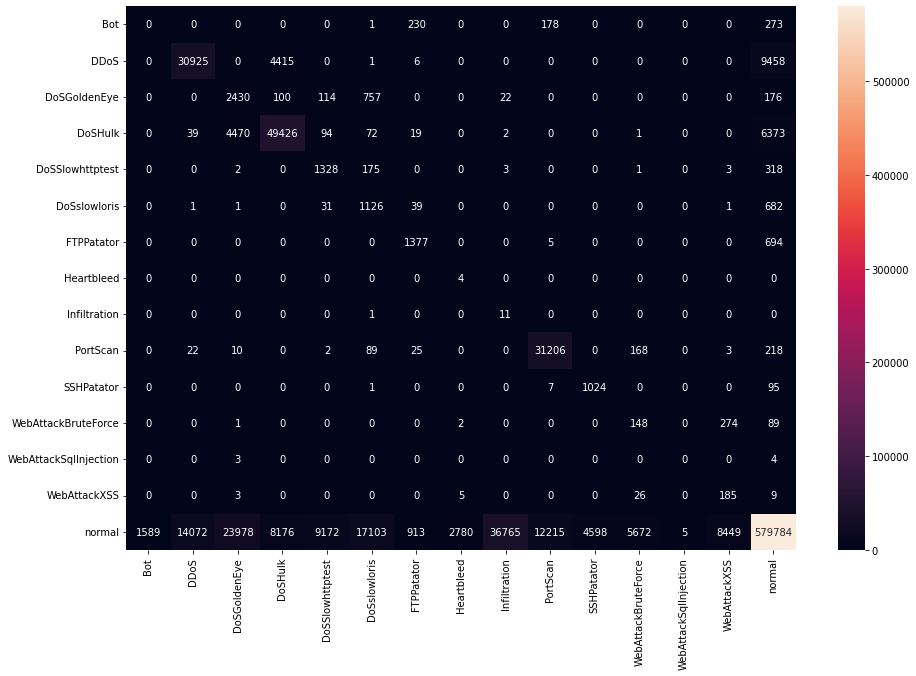

In [27]:
evaluate(Y_test,bnb_predictions)

/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       682
           1       0.82      0.58      0.68     44805
           2       0.84      0.08      0.15      3599
           3       0.90      0.81      0.85     60496
           4       0.00      0.00      0.00      1830
           5       0.00      0.00      0.00      1881
           6       0.00      0.00      0.00      2076
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        12
           9       0.27      0.01      0.02     31743
          10       0.00      0.00      0.00      1127
          11       0.00      0.00      0.00       514
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00       228
          14       0.92      1.00      0.95    725271

    accuracy                           0.91    874275
   macro avg       0.25      0.16      0.18    874275
wei

/home/bot/myprojectdir/myprojectenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted precision = 0.8784
Weighted recall = 0.9117



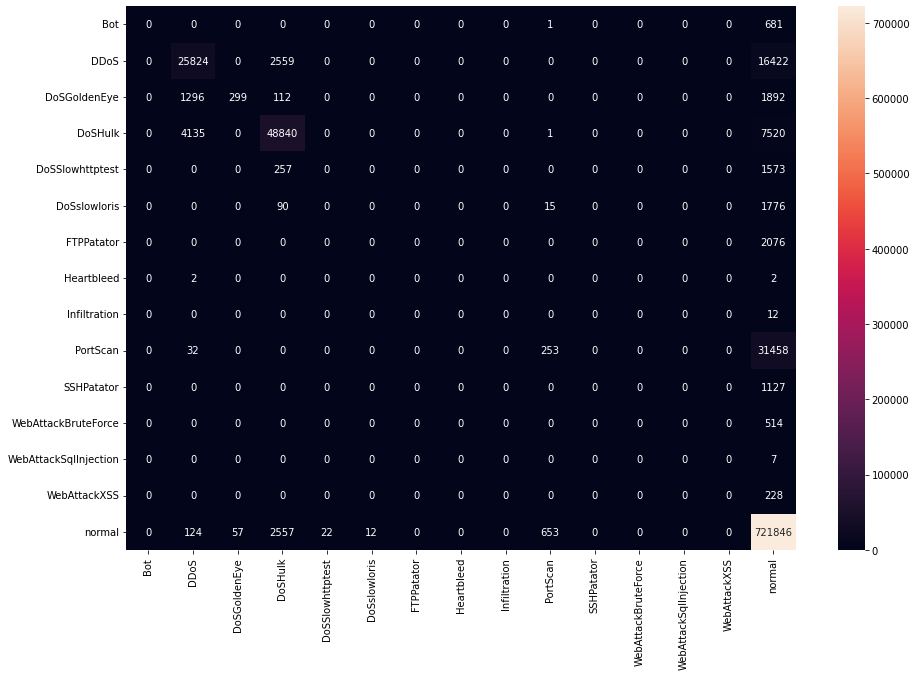

In [28]:
evaluate(Y_test,lr_predictions)

## Improving

In [34]:
DTC_Classifier.get_depth()

30

In [35]:
DTC_Classifier.get_n_leaves()

2398

In [42]:
startDT = time.time()
# Training Decision Tree models
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=0,max_depth=15)
#The division quality measurement function supports the "die" criteria for dirt and the "entropy" criteria for obtaining information,
DTC_Classifier.fit(X_train, Y_train)
print("Training time model decision tree", time.time()-startDT)

Training time model decision tree 45.297353744506836


In [43]:
st_time =time.time()
dt_predictions = DTC_Classifier.predict(X_test)
end_time = time.time()
print('Prediction time for Decision Tree testing data = %s'%(end_time-st_time))

Prediction time for Decision Tree testing data = 0.1346909999847412


### OVERALL REPORT ###
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       682
           1       1.00      1.00      1.00     44805
           2       0.99      0.99      0.99      3599
           3       0.99      1.00      1.00     60496
           4       0.98      0.99      0.99      1830
           5       0.99      0.99      0.99      1881
           6       1.00      1.00      1.00      2076
           7       1.00      1.00      1.00         4
           8       0.82      0.75      0.78        12
           9       0.99      1.00      0.99     31743
          10       1.00      0.99      1.00      1127
          11       0.69      0.94      0.80       514
          12       0.22      0.29      0.25         7
          13       0.45      0.07      0.11       228
          14       1.00      1.00      1.00    725271

    accuracy                           1.00    874275
   macro avg       0.87      0.85      0.85    874275
wei

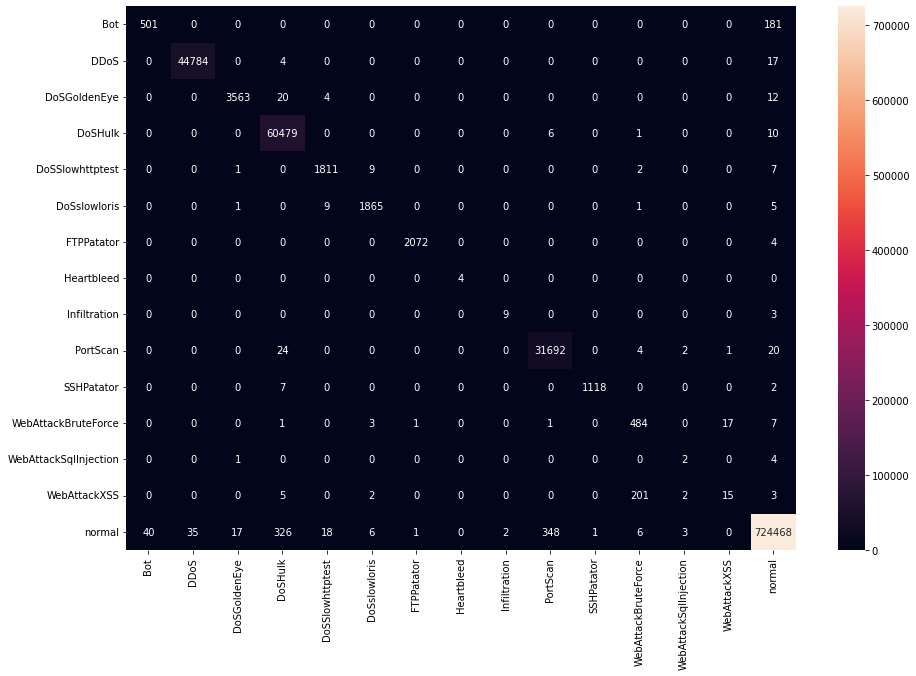

In [44]:
evaluate(Y_test,dt_predictions)